# How to identify gentrified areas?

1. measure both housing price increases and changes in deprivation levels. 
2. calculate the **percentage increase** in average housing prices for each area over the five-year period
3. use the IMD to assess whether the area's deprivation level has improved—measured by a drop in IMD decile scores

Areas where **both** house prices and IMD scores rose faster than average are flagged as likely to be experiencing gentrification.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [2]:
import sys
print(sys.executable)

e:\dissertation\project\housing_feature_gentrification\venv\Scripts\python.exe


## House price

In [3]:
# reading house price
house_path = "data/gentri_data/HPSSA_Dataset_46_Median_price_paid_for_residential_properties_by_LSOA.xls"
house_price = pd.ExcelFile(house_path)

In [4]:
# reading sheet
df_house = house_price.parse(sheet_name="1a", header = 5) 
df_house.head()

Local authority code Local authority name  LSOA code        LSOA name  \
0            E06000001           Hartlepool  E01011949  Hartlepool 009A   
1            E06000001           Hartlepool  E01011950  Hartlepool 008A   
2            E06000001           Hartlepool  E01011951  Hartlepool 007A   
3            E06000001           Hartlepool  E01011952  Hartlepool 002A   
4            E06000001           Hartlepool  E01011953  Hartlepool 002B   

  Year ending Dec 1995 Year ending Mar 1996 Year ending Jun 1996  \
0                34750                34500                30500   
1                25000                25000                25300   
2                27000                27000                27250   
3                44500                44500                30000   
4                22000                27000                27000   

  Year ending Sep 1996 Year ending Dec 1996 Year ending Mar 1997  ...  \
0                30000                29950                29000  ...   
1                25625                25000                24800  ...   
2                28950                28500                28950  ...   
3                26675                26000                25500  ...   
4                20600                20000                19500  ...   

  Year ending Dec 2020 Year ending Mar 2021 Year ending Jun 2021  \
0                88000                81500                80500   
1                29750                33000                47000   
2                50000                51500                53000   
3                85000                    :                83500   
4                    :                    :                    :   

  Year ending Sep 2021 Year ending Dec 2021 Year ending Mar 2022  \
0                89000               101500                94500   
1                49999                50159                50159   
2              58573.5                60000                62999   
3                83000                80000                76000   
4                95000                92500                95000   

  Year ending Jun 2022 Year ending Sep 2022 Year ending Dec 2022  \
0               113000                97500               102500   
1                46000                43500                42000   
2              61499.5                60000              65499.5   
3                75000                75000                70000   
4                95000                92500                93750   

  Year ending Mar 2023  
0               106500  
1                43500  
2                66000  
3                60000  
4                92500  

[5 rows x 114 columns]

In [5]:
# select the column that's needed
house_columns_needed = ['LSOA code', 'LSOA name', 
                        'Year ending Dec 2015', 'Year ending Sep 2015', 'Year ending Jun 2015', 'Year ending Mar 2015',
                        'Year ending Dec 2019', 'Year ending Sep 2019', 'Year ending Jun 2019', 'Year ending Mar 2019'] 
df_house_select = df_house[house_columns_needed]
df_house_select.head()

LSOA code        LSOA name Year ending Dec 2015 Year ending Sep 2015  \
0  E01011949  Hartlepool 009A                73000                77000   
1  E01011950  Hartlepool 008A                29400                29150   
2  E01011951  Hartlepool 007A                46000                50000   
3  E01011952  Hartlepool 002A              63747.5              63747.5   
4  E01011953  Hartlepool 002B                65000                60500   

  Year ending Jun 2015 Year ending Mar 2015 Year ending Dec 2019  \
0                68500                69000                77000   
1                29000                29250                27500   
2                56500                50500              39997.5   
3                51000                56750                66475   
4                61000                60000                58000   

  Year ending Sep 2019 Year ending Jun 2019 Year ending Mar 2019  
0                77500                77500                73250  
1                27000                29500                28000  
2                42800                46250                50000  
3                70000                70000                70000  
4                62000                59000                66000

In [6]:
# read in lsoa shapefile
london_gdf = gpd.read_file("data/statistical-gis-boundaries-london/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")

# extract lsoa11cd as LSOA list
london_lsoa_list = london_gdf['LSOA11CD'].unique()

In [7]:
# select data in London area
df_london_price = df_house_select[df_house_select['LSOA code'].isin(london_lsoa_list)]
df_london_price.dtypes

LSOA code               object
LSOA name               object
Year ending Dec 2015    object
Year ending Sep 2015    object
Year ending Jun 2015    object
Year ending Mar 2015    object
Year ending Dec 2019    object
Year ending Sep 2019    object
Year ending Jun 2019    object
Year ending Mar 2019    object
dtype: object

In [8]:
# turn object into float
columns_to_convert = [
    'Year ending Mar 2015', 'Year ending Jun 2015',
    'Year ending Sep 2015', 'Year ending Dec 2015',
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019'
]

df_london_price[columns_to_convert] = (df_london_price[columns_to_convert].apply(pd.to_numeric, errors='coerce'))

C:\Users\hp\AppData\Local\Temp\ipykernel_11884\3000649747.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price[columns_to_convert] = (df_london_price[columns_to_convert].apply(pd.to_numeric, errors='coerce'))


In [9]:
# calculating the mean of 2015 and 2019
df_london_price['2015'] = df_london_price[[
    'Year ending Mar 2015', 'Year ending Jun 2015',
    'Year ending Sep 2015', 'Year ending Dec 2015'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price['2019'] = df_london_price[[
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

C:\Users\hp\AppData\Local\Temp\ipykernel_11884\335151379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price['2015'] = df_london_price[[
C:\Users\hp\AppData\Local\Temp\ipykernel_11884\335151379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price['2019'] = df_london_price[[


In [10]:
# calculating the chage(Relative Growth Rate) percentage between 2015 to 2019
df_london_price.loc[:, 'price_growth'] = (df_london_price['2019'] - df_london_price['2015']) / df_london_price['2015']
df_london_price.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1424116064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price.loc[:, 'price_growth'] = (df_london_price['2019'] - df_london_price['2015']) / df_london_price['2015']


LSOA code            LSOA name  Year ending Dec 2015  \
28009  E01000001  City of London 001A              872500.0   
28010  E01000002  City of London 001B              844525.0   
28011  E01000003  City of London 001C              525000.0   
28012  E01000005  City of London 001E              510000.0   
28013  E01032739  City of London 001F              785000.0   

       Year ending Sep 2015  Year ending Jun 2015  Year ending Mar 2015  \
28009              870000.0              907500.0              883000.0   
28010              800000.0              765000.0              735520.0   
28011              500000.0              520000.0              520000.0   
28012              430000.0              372500.0              399000.0   
28013              835350.0              818200.0              835000.0   

       Year ending Dec 2019  Year ending Sep 2019  Year ending Jun 2019  \
28009              865000.0              887500.0              847500.0   
28010              862500.0              880000.0              857500.0   
28011              515000.0              572500.0              599000.0   
28012                   NaN                   NaN                   NaN   
28013             1500000.0              996075.0              941160.0   

       Year ending Mar 2019       2015        2019  price_growth  
28009              815000.0  883250.00   853750.00     -0.033399  
28010              835000.0  786261.25   858750.00      0.092194  
28011              599500.0  516250.00   571500.00      0.107022  
28012                   NaN  427875.00         NaN           NaN  
28013              964500.0  818387.50  1100433.75      0.344637

### ! Important
price dataset has missing data

In [11]:
df_london_price.isna().sum()

LSOA code                 0
LSOA name                 0
Year ending Dec 2015    120
Year ending Sep 2015    122
Year ending Jun 2015    102
Year ending Mar 2015    116
Year ending Dec 2019    416
Year ending Sep 2019    437
Year ending Jun 2019    412
Year ending Mar 2019    396
2015                     55
2019                    204
price_growth            226
dtype: int64

In [12]:
# delete all the na data
df_house_price_cleaned = df_london_price.dropna(subset=['2015', '2019', 'price_growth'])
df_house_price_cleaned.shape

(4609, 13)

## IMD

- imd score: the larger the score, the more deprived the area (and the lower its rank)

- imd rank: the lower the rank, the more deprived the area

the rank is not isometric, one rank between different lsoas may not be the same, so i think it‘s better to use scores to calculate the rate

In [13]:
# read in imd data
# 2019
imd_2019 = pd.ExcelFile("data/gentri_data/File_5_-_IoD2019_Scores.xlsx")
df_imd_2019 = imd_2019.parse(sheet_name="IoD2019 Scores") 
df_imd_2019.head()

LSOA code (2011)           LSOA name (2011)  \
0        E01000001        City of London 001A   
1        E01000002        City of London 001B   
2        E01000003        City of London 001C   
3        E01000005        City of London 001E   
4        E01000006  Barking and Dagenham 016A   

  Local Authority District code (2019) Local Authority District name (2019)  \
0                            E09000001                       City of London   
1                            E09000001                       City of London   
2                            E09000001                       City of London   
3                            E09000001                       City of London   
4                            E09000002                 Barking and Dagenham   

   Index of Multiple Deprivation (IMD) Score  Income Score (rate)  \
0                                      6.208                0.007   
1                                      5.143                0.034   
2                                     19.402                0.086   
3                                     28.652                0.211   
4                                     19.837                0.117   

   Employment Score (rate)  Education, Skills and Training Score  \
0                    0.010                                 0.024   
1                    0.027                                 0.063   
2                    0.086                                 5.804   
3                    0.136                                22.260   
4                    0.059                                14.798   

   Health Deprivation and Disability Score  Crime Score  \
0                                   -1.654       -2.012   
1                                   -1.115       -2.343   
2                                   -0.102       -1.032   
3                                   -0.121       -1.317   
4                                   -0.359       -0.147   

   Barriers to Housing and Services Score  Living Environment Score  \
0                                  29.472                    31.873   
1                                  24.412                    23.084   
2                                  40.103                    40.535   
3                                  39.900                    28.979   
4                                  45.171                    26.888   

   Income Deprivation Affecting Children Index (IDACI) Score (rate)  \
0                                              0.006                  
1                                              0.037                  
2                                              0.052                  
3                                              0.209                  
4                                              0.155                  

   Income Deprivation Affecting Older People (IDAOPI) Score (rate)  \
0                                              0.012                 
1                                              0.030                 
2                                              0.128                 
3                                              0.322                 
4                                              0.162                 

   Children and Young People Sub-domain Score  Adult Skills Sub-domain Score  \
0                                      -2.107                          0.032   
1                                      -1.907                          0.034   
2                                      -0.292                          0.142   
3                                       0.338                          0.321   
4                                      -0.366                          0.325   

   Geographical Barriers Sub-domain Score  Wider Barriers Sub-domain Score  \
0                                  -0.430                            3.587   
1                                  -1.060                            3.231   
2                                  -0.691                      

In [14]:
# select *Index of Multiple Deprivation (IMD) Score* in London area
df_imd_2019_only = df_imd_2019[['LSOA code (2011)', 'LSOA name (2011)', 'Index of Multiple Deprivation (IMD) Score']]
df_imd_2019_only.head()

LSOA code (2011)           LSOA name (2011)  \
0        E01000001        City of London 001A   
1        E01000002        City of London 001B   
2        E01000003        City of London 001C   
3        E01000005        City of London 001E   
4        E01000006  Barking and Dagenham 016A   

   Index of Multiple Deprivation (IMD) Score  
0                                      6.208  
1                                      5.143  
2                                     19.402  
3                                     28.652  
4                                     19.837

In [15]:
df_london_imd_2019 = df_imd_2019_only[df_imd_2019_only['LSOA code (2011)'].isin(london_lsoa_list)]
df_london_imd_2019.shape

(4835, 3)

In [16]:
#2015
imd_2015 = pd.ExcelFile("data/gentri_data/File_5_ID_2015_Scores_for_the_Indices_of_Deprivation.xlsx")
df_imd_2015 = imd_2015.parse(sheet_name="ID2015 Scores") 
df_imd_2015.head()

LSOA code (2011) LSOA name (2011) Local Authority District code (2013)  \
0        E01031349        Adur 001A                            E07000223   
1        E01031350        Adur 001B                            E07000223   
2        E01031351        Adur 001C                            E07000223   
3        E01031352        Adur 001D                            E07000223   
4        E01031370        Adur 001E                            E07000223   

  Local Authority District name (2013)  \
0                                 Adur   
1                                 Adur   
2                                 Adur   
3                                 Adur   
4                                 Adur   

   Index of Multiple Deprivation (IMD) Score  Income Score (rate)  \
0                                     12.389                0.096   
1                                     28.619                0.187   
2                                     11.713                0.065   
3                                     16.446                0.117   
4                                     18.265                0.102   

   Employment Score (rate)  Education, Skills and Training Score  \
0                    0.083                                20.055   
1                    0.162                                34.653   
2                    0.066                                26.334   
3                    0.113                                25.779   
4                    0.115                                32.056   

   Health Deprivation and Disability Score  Crime Score  \
0                                   -0.718        0.242   
1                                    0.722        0.244   
2                                   -0.616        0.495   
3                                   -0.234        0.026   
4                                    0.082        0.182   

   Barriers to Housing and Services Score  Living Environment Score  \
0                                  10.586                    15.180   
1                                  24.689                    17.837   
2                                  13.631                    11.150   
3                                  17.803                    10.677   
4                                  15.482                    15.378   

   Income Deprivation Affecting Children Index (IDACI) Score (rate)  \
0                                              0.143                  
1                                              0.211                  
2                                              0.077                  
3                                              0.210                  
4                                              0.117                  

   Income Deprivation Affecting Older People (IDAOPI) Score (rate)  \
0                                              0.103                 
1                                              0.269                 
2                                              0.079                 
3                                              0.087                 
4                                              0.131                 

   Children and Young People Sub-domain Score  Adult Skills Sub-domain Score  \
0                                       0.098                          0.333   
1                                       0.470                          0.426   
2                                       0.395                          0.357   
3                                       0.348                          0.359   
4                                       0.840                          0.338   

   Geographical Barriers Sub-domain Score  Wider Barriers Sub-domain Score  \
0                                  -0.346                           -0.721   
1                                   0.234                            1.104   
2                                   0.035                           -1.048   
3                                   0.233    

In [17]:
df_imd_2015_only = df_imd_2015[['LSOA code (2011)', 'Index of Multiple Deprivation (IMD) Score']]
df_imd_2015_only.head()

LSOA code (2011)  Index of Multiple Deprivation (IMD) Score
0        E01031349                                     12.389
1        E01031350                                     28.619
2        E01031351                                     11.713
3        E01031352                                     16.446
4        E01031370                                     18.265

In [18]:
df_london_imd_2015 = df_imd_2015_only[df_imd_2015_only['LSOA code (2011)'].isin(london_lsoa_list)]
df_london_imd_2015.shape

(4835, 2)

In [19]:
# merge two dataframe
df_london_imd = pd.merge(
    df_london_imd_2015,
    df_london_imd_2019,
    on='LSOA code (2011)',
    suffixes=('_2015', '_2019')
)

As the larger imd score means more deprived area is, we need to calculate the decrese between 2015 -2019 to represent the increase of the area. S here I use the date of 2015 to minus 2019.

In [20]:
# calculate improving rate
df_london_imd['imd_score_improve'] = (
    df_london_imd['Index of Multiple Deprivation (IMD) Score_2015'] - 
    df_london_imd['Index of Multiple Deprivation (IMD) Score_2019']
) / df_london_imd['Index of Multiple Deprivation (IMD) Score_2015']

df_london_imd.head()

LSOA code (2011)  Index of Multiple Deprivation (IMD) Score_2015  \
0        E01000027                                          41.997   
1        E01000028                                          43.130   
2        E01000029                                          26.669   
3        E01000030                                          41.284   
4        E01000031                                          25.078   

            LSOA name (2011)  Index of Multiple Deprivation (IMD) Score_2019  \
0  Barking and Dagenham 001A                                          37.347   
1  Barking and Dagenham 001B                                          40.078   
2  Barking and Dagenham 001C                                          22.503   
3  Barking and Dagenham 001D                                          38.415   
4  Barking and Dagenham 002A                                          22.672   

   imd_score_improve  
0           0.110722  
1           0.070763  
2           0.156211  
3           0.069494  
4           0.095941

In [21]:
## Education
edu = pd.read_csv("data/stru_data/education.csv", header = 6)
edu.head(5)
# select columns
edu['LSOA code'] = edu['2011 super output area - lower layer'].str.split(':').str[0].str.strip()
edu_col = ['LSOA code', 'Highest level of qualification: Level 4 qualifications and above', '%.5']
df_edu = edu[edu_col]
df_edu.rename(columns={'Highest level of qualification: Level 4 qualifications and above': 'level_4_pop'}, inplace=True)
df_edu.rename(columns={'%.5': 'level_4_per'}, inplace=True)
# select data in London area
df_london_edu = df_edu[df_edu['LSOA code'].isin(london_lsoa_list)]
df_london_edu.shape
edu_numeric = df_london_edu.select_dtypes(include=['number'])
df_london_edu[edu_numeric.columns] = edu_numeric.fillna(0)
print(df_london_edu)

       LSOA code  level_4_pop  level_4_per
0      E01000001       1047.0         77.6
1      E01000002       1024.0         79.2
2      E01000003        706.0         56.8
3      E01000005        283.0         34.5
4      E01000006        431.0         32.9
...          ...          ...          ...
32817  E01033742        532.0         48.3
32818  E01033743        533.0         40.9
32819  E01033744        404.0         29.1
32820  E01033745        463.0         38.0
32821  E01033746        713.0         56.8

[4835 rows x 3 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1386714628.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edu.rename(columns={'Highest level of qualification: Level 4 qualifications and above': 'level_4_pop'}, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1386714628.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edu.rename(columns={'%.5': 'level_4_per'}, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1386714628.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [22]:
## Occupation
occ = pd.read_csv("data/stru_data/occupation.csv", header = 7)
occ.head(5)
# select columns
occ['LSOA code'] = occ['2011 super output area - lower layer'].str.split(':').str[0].str.strip()
occ_col = ['LSOA code', '2. Professional occupations', '%.2']
df_occ = occ[occ_col]
df_occ.rename(columns={'2. Professional occupations': 'prof_occ_count'}, inplace=True)
df_occ.rename(columns={'%.2': 'prof_occ_per'}, inplace=True)
# select data in London area
df_london_occ = df_occ[df_occ['LSOA code'].isin(london_lsoa_list)]
df_london_occ.shape
occ_numeric = df_london_occ.select_dtypes(include=['number'])
df_london_occ[occ_numeric.columns] = occ_numeric.fillna(0)
print(df_london_occ)


C:\Users\hp\AppData\Local\Temp\ipykernel_11884\2083839324.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  occ = pd.read_csv("data/stru_data/occupation.csv", header = 7)


       LSOA code  prof_occ_count  prof_occ_per
0      E01000001           446.0          48.2
1      E01000002           417.0          45.8
2      E01000003           285.0          37.3
3      E01000005            81.0          17.0
4      E01000006           140.0          17.9
...          ...             ...           ...
32817  E01033742           204.0          26.7
32818  E01033743           180.0          22.0
32819  E01033744           120.0          15.5
32820  E01033745           146.0          18.5
32821  E01033746           299.0          37.9

[4835 rows x 3 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_11884\2083839324.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_occ.rename(columns={'2. Professional occupations': 'prof_occ_count'}, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_11884\2083839324.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_occ.rename(columns={'%.2': 'prof_occ_per'}, inplace=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_11884\2083839324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

## Gentrified areas

In [23]:
df_london_imd.rename(columns={'LSOA code (2011)': 'LSOA code'}, inplace=True)

In [24]:
df_london_all = pd.merge(
    df_house_price_cleaned,
    df_london_imd,
    on='LSOA code',
    how='inner'  # only keep the lsoa that have both data
)

In [25]:
df_london_all = df_london_all.merge(df_london_edu, on='LSOA code', how='left')
df_london_all = df_london_all.merge(df_london_occ, on='LSOA code', how='left')
print(df_london_all.columns)

Index(['LSOA code', 'LSOA name', 'Year ending Dec 2015',
       'Year ending Sep 2015', 'Year ending Jun 2015', 'Year ending Mar 2015',
       'Year ending Dec 2019', 'Year ending Sep 2019', 'Year ending Jun 2019',
       'Year ending Mar 2019', '2015', '2019', 'price_growth',
       'Index of Multiple Deprivation (IMD) Score_2015', 'LSOA name (2011)',
       'Index of Multiple Deprivation (IMD) Score_2019', 'imd_score_improve',
       'level_4_pop', 'level_4_per', 'prof_occ_count', 'prof_occ_per'],
      dtype='object')


In [26]:
# calculate the averages
mean_price_growth = df_london_all['price_growth'].mean()
mean_imd_improve = df_london_all['imd_score_improve'].mean()
mean_edu = df_london_all['level_4_per'].mean()
mean_occ = df_london_all['prof_occ_per'].mean()
# add labels
df_london_all['high_price_growth'] = df_london_all['price_growth'] > mean_price_growth
df_london_all['high_imd_improvement'] = df_london_all['imd_score_improve'] > mean_imd_improve
df_london_all['high_edu'] = df_london_all['level_4_per'] > mean_edu
df_london_all['high_occ'] = df_london_all['prof_occ_per'] > mean_edu
df_london_all.head()

LSOA code            LSOA name  Year ending Dec 2015  Year ending Sep 2015  \
0  E01000001  City of London 001A              872500.0              870000.0   
1  E01000002  City of London 001B              844525.0              800000.0   
2  E01000003  City of London 001C              525000.0              500000.0   
3  E01032739  City of London 001F              785000.0              835350.0   
4  E01032740  City of London 001G              885000.0              911750.0   

   Year ending Jun 2015  Year ending Mar 2015  Year ending Dec 2019  \
0              907500.0              883000.0              865000.0   
1              765000.0              735520.0              862500.0   
2              520000.0              520000.0              515000.0   
3              818200.0              835000.0             1500000.0   
4              880000.0              880000.0              874000.0   

   Year ending Sep 2019  Year ending Jun 2019  Year ending Mar 2019  ...  \
0              887500.0              847500.0              815000.0  ...   
1              880000.0              857500.0              835000.0  ...   
2              572500.0              599000.0              599500.0  ...   
3              996075.0              941160.0              964500.0  ...   
4             1054000.0             1357250.0             1277750.0  ...   

   Index of Multiple Deprivation (IMD) Score_2019  imd_score_improve  \
0                                           6.208          -0.023916   
1                                           5.143           0.177778   
2                                          19.402           0.007469   
3                                          13.584          -0.031513   
4                                          15.841          -0.071786   

   level_4_pop  level_4_per prof_occ_count  prof_occ_per  high_price_growth  \
0       1047.0         77.6          446.0          48.2              False   
1       1024.0         79.2          417.0          45.8              False   
2        706.0         56.8          285.0          37.3              False   
3        721.0         73.6          286.0          34.9               True   
4        837.0         78.2          379.0          44.5               True   

   high_imd_improvement  high_edu  high_occ  
0                 False      True      True  
1                  True      True      True  
2                 False      True     False  
3                 False      True     False  
4                 False      True      True  

[5 rows x 25 columns]

In [27]:
# identify gentrification
df_london_all['gentrified'] = df_london_all['high_price_growth'] & df_london_all['high_imd_improvement'] & df_london_all['high_edu']
df_london_all['gentrified'].value_counts()

gentrified
False    4243
True      366
Name: count, dtype: int64

In [28]:
# save a copy
df_london_all.to_csv("data/london_gentrification_analysis.csv", index=False)

In [29]:
# plot maps
# change the column name in shp
london_gdf.rename(columns={'LSOA11CD': 'LSOA code'}, inplace=True)

In [30]:
# merge data with shp
london_gdf_merged = london_gdf.merge(df_london_all, on='LSOA code', how='inner')

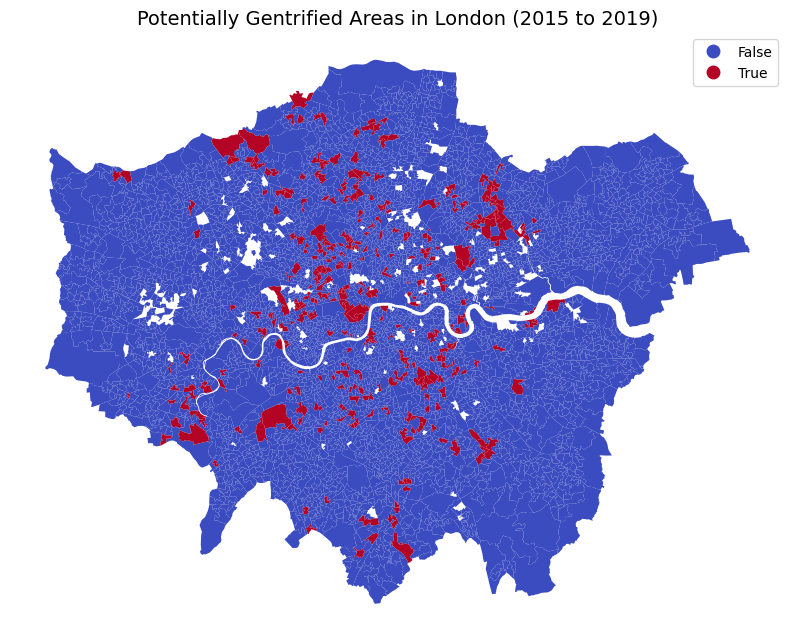

In [31]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_gdf_merged.plot(column='gentrified', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Potentially Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

Gentrification appears to be spatially scattered, with clusters emerging in **parts of Inner East and South London** — particularly in boroughs such as Hackney, Southwark, and Newham. 

However, the dispersed nature of red zones suggests that gentrification may be occurring at a **micro-level**, rather than through broad borough-wide transformations.

## Missing data

1. Check if the missing data is caused by the change of lsoa
    - Missing data are not concentrated in certain specific areas, but are scattered across multiple LSOAs. More importantly, the   missing situations in the same LSOA *vary in different years and quarters*, indicating that the missing data have discontinuity in time. Therefore, the missing data can be preliminarily ruled out as being caused by structural changes such as LSOA boundary adjustments or code replacements.
2. Fill the lsoa with data from other years
3. Fill the lsoa with the average data from its neighbour

In [32]:
# try to see if there are data from other years
house_columns_needed_all = ['LSOA code', 'LSOA name', 
                        'Year ending Dec 2014', 'Year ending Sep 2014', 'Year ending Jun 2014', 'Year ending Mar 2014',
                        'Year ending Dec 2015', 'Year ending Sep 2015', 'Year ending Jun 2015', 'Year ending Mar 2015',
                        'Year ending Dec 2016', 'Year ending Sep 2016', 'Year ending Jun 2016', 'Year ending Mar 2016',
                        'Year ending Dec 2017', 'Year ending Sep 2017', 'Year ending Jun 2017', 'Year ending Mar 2017',
                        'Year ending Dec 2018', 'Year ending Sep 2018', 'Year ending Jun 2018', 'Year ending Mar 2018',
                        'Year ending Dec 2019', 'Year ending Sep 2019', 'Year ending Jun 2019', 'Year ending Mar 2019',
                        'Year ending Dec 2020', 'Year ending Sep 2020', 'Year ending Jun 2020', 'Year ending Mar 2020'] 
df_house_select_all = df_house[house_columns_needed_all]
df_house_select_all.head()

LSOA code        LSOA name Year ending Dec 2014 Year ending Sep 2014  \
0  E01011949  Hartlepool 009A                68000                66000   
1  E01011950  Hartlepool 008A                30000                32000   
2  E01011951  Hartlepool 007A                51000                51000   
3  E01011952  Hartlepool 002A                51000                60000   
4  E01011953  Hartlepool 002B                55000                68000   

  Year ending Jun 2014 Year ending Mar 2014 Year ending Dec 2015  \
0                73000                73000                73000   
1                32000                34500                29400   
2                55250                48750                46000   
3                60000              64237.5              63747.5   
4                53250                52500                65000   

  Year ending Sep 2015 Year ending Jun 2015 Year ending Mar 2015  ...  \
0                77000                68500                69000  ...   
1                29150                29000                29250  ...   
2                50000                56500                50500  ...   
3              63747.5                51000                56750  ...   
4                60500                61000                60000  ...   

  Year ending Jun 2018 Year ending Mar 2018 Year ending Dec 2019  \
0                88000                85000                77000   
1                30000                30475                27500   
2                44500              44499.5              39997.5   
3                63000                65750                66475   
4                62500                50000                58000   

  Year ending Sep 2019 Year ending Jun 2019 Year ending Mar 2019  \
0                77500                77500                73250   
1                27000                29500                28000   
2                42800                46250                50000   
3                70000                70000                70000   
4                62000                59000                66000   

  Year ending Dec 2020 Year ending Sep 2020 Year ending Jun 2020  \
0                88000                88000                84000   
1                29750                28000                26000   
2                50000                30000                29425   
3                85000                85000                66475   
4                    :                    :                60000   

  Year ending Mar 2020  
0                89000  
1                27000  
2                40000  
3                70000  
4                58000  

[5 rows x 30 columns]

In [33]:
# select data in London area
df_london_price_all = df_house_select_all[df_house_select_all['LSOA code'].isin(london_lsoa_list)]
df_london_price_all.dtypes

LSOA code               object
LSOA name               object
Year ending Dec 2014    object
Year ending Sep 2014    object
Year ending Jun 2014    object
Year ending Mar 2014    object
Year ending Dec 2015    object
Year ending Sep 2015    object
Year ending Jun 2015    object
Year ending Mar 2015    object
Year ending Dec 2016    object
Year ending Sep 2016    object
Year ending Jun 2016    object
Year ending Mar 2016    object
Year ending Dec 2017    object
Year ending Sep 2017    object
Year ending Jun 2017    object
Year ending Mar 2017    object
Year ending Dec 2018    object
Year ending Sep 2018    object
Year ending Jun 2018    object
Year ending Mar 2018    object
Year ending Dec 2019    object
Year ending Sep 2019    object
Year ending Jun 2019    object
Year ending Mar 2019    object
Year ending Dec 2020    object
Year ending Sep 2020    object
Year ending Jun 2020    object
Year ending Mar 2020    object
dtype: object

In [34]:
# turn object into float
columns_to_convert_all = [
    'Year ending Mar 2014', 'Year ending Jun 2014',
    'Year ending Sep 2014', 'Year ending Dec 2014',
    'Year ending Mar 2015', 'Year ending Jun 2015',
    'Year ending Sep 2015', 'Year ending Dec 2015',
    'Year ending Mar 2016', 'Year ending Jun 2016',
    'Year ending Sep 2016', 'Year ending Dec 2016',
    'Year ending Mar 2017', 'Year ending Jun 2017',
    'Year ending Sep 2017', 'Year ending Dec 2017',
    'Year ending Mar 2018', 'Year ending Jun 2018',
    'Year ending Sep 2018', 'Year ending Dec 2018',
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019',
    'Year ending Mar 2020', 'Year ending Jun 2020',
    'Year ending Sep 2020', 'Year ending Dec 2020',
]

df_london_price_all[columns_to_convert_all] = (df_london_price_all[columns_to_convert_all].apply(pd.to_numeric, errors='coerce'))

C:\Users\hp\AppData\Local\Temp\ipykernel_11884\4254129738.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price_all[columns_to_convert_all] = (df_london_price_all[columns_to_convert_all].apply(pd.to_numeric, errors='coerce'))


In [35]:
# calculating the mean of 2015 and 2019
df_london_price_all['2014'] = df_london_price_all[[
    'Year ending Mar 2014', 'Year ending Jun 2014',
    'Year ending Sep 2014', 'Year ending Dec 2014'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2015'] = df_london_price_all[[
    'Year ending Mar 2015', 'Year ending Jun 2015',
    'Year ending Sep 2015', 'Year ending Dec 2015'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2016'] = df_london_price_all[[
    'Year ending Mar 2016', 'Year ending Jun 2016',
    'Year ending Sep 2016', 'Year ending Dec 2016'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2017'] = df_london_price_all[[
    'Year ending Mar 2017', 'Year ending Jun 2017',
    'Year ending Sep 2017', 'Year ending Dec 2017'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2018'] = df_london_price_all[[
    'Year ending Mar 2018', 'Year ending Jun 2018',
    'Year ending Sep 2018', 'Year ending Dec 2018'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2019'] = df_london_price_all[[
    'Year ending Mar 2019', 'Year ending Jun 2019',
    'Year ending Sep 2019', 'Year ending Dec 2019'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)

df_london_price_all['2020'] = df_london_price_all[[
    'Year ending Mar 2020', 'Year ending Jun 2020',
    'Year ending Sep 2020', 'Year ending Dec 2020'
]].apply(pd.to_numeric, errors='coerce').mean(axis=1)


C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1714176764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price_all['2014'] = df_london_price_all[[
C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1714176764.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_london_price_all['2015'] = df_london_price_all[[
C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1714176764.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [36]:
# see what's the missing data like
df_london_price_all.isna().sum()

LSOA code                 0
LSOA name                 0
Year ending Dec 2014    107
Year ending Sep 2014     91
Year ending Jun 2014    105
Year ending Mar 2014    121
Year ending Dec 2015    120
Year ending Sep 2015    122
Year ending Jun 2015    102
Year ending Mar 2015    116
Year ending Dec 2016    192
Year ending Sep 2016    153
Year ending Jun 2016    121
Year ending Mar 2016     91
Year ending Dec 2017    283
Year ending Sep 2017    269
Year ending Jun 2017    279
Year ending Mar 2017    276
Year ending Dec 2018    359
Year ending Sep 2018    341
Year ending Jun 2018    339
Year ending Mar 2018    304
Year ending Dec 2019    416
Year ending Sep 2019    437
Year ending Jun 2019    412
Year ending Mar 2019    396
Year ending Dec 2020    521
Year ending Sep 2020    519
Year ending Jun 2020    486
Year ending Mar 2020    398
2014                     44
2015                     55
2016                     57
2017                    121
2018                    157
2019                

In [37]:
df = df_london_price_all.copy()

# creat a column to copy the date in 2015 and 2019, then fill the blank with data from similar year
df['2015_filled'] = df['2015']
df['2015_filled'] = df['2015_filled'].fillna(
    df[['2014', '2016']].mean(axis=1)
)

df['2019_filled'] = df['2019']
df['2019_filled'] = df['2019_filled'].fillna(
    df[['2018', '2020']].mean(axis=1)
)

In [38]:
df.isna().sum()

LSOA code                 0
LSOA name                 0
Year ending Dec 2014    107
Year ending Sep 2014     91
Year ending Jun 2014    105
Year ending Mar 2014    121
Year ending Dec 2015    120
Year ending Sep 2015    122
Year ending Jun 2015    102
Year ending Mar 2015    116
Year ending Dec 2016    192
Year ending Sep 2016    153
Year ending Jun 2016    121
Year ending Mar 2016     91
Year ending Dec 2017    283
Year ending Sep 2017    269
Year ending Jun 2017    279
Year ending Mar 2017    276
Year ending Dec 2018    359
Year ending Sep 2018    341
Year ending Jun 2018    339
Year ending Mar 2018    304
Year ending Dec 2019    416
Year ending Sep 2019    437
Year ending Jun 2019    412
Year ending Mar 2019    396
Year ending Dec 2020    521
Year ending Sep 2020    519
Year ending Jun 2020    486
Year ending Mar 2020    398
2014                     44
2015                     55
2016                     57
2017                    121
2018                    157
2019                

Here we can see most of the missing data has been filled, but there's still 18 for 2015 and 68 for 2019.
We can further try to use the nearby lsoas' average data to fill it.

Here i used KNN, queens connection didn't succeed.

In [39]:
print(london_gdf.columns)

Index(['LSOA code', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry'],
      dtype='object')


In [40]:
# use the coordinate in Britain
london_gdf_27700 = london_gdf.to_crs(epsg=27700)

In [41]:
print("empty geo：", london_gdf_27700.geometry.is_empty.sum())
print("missing geo：", london_gdf_27700.geometry.isna().sum())


empty geo： 0
missing geo： 0


In [42]:
# merge the geo data with column 2015 and 2019
london_gdf_27700 =  london_gdf_27700.merge(
    df[['LSOA code', '2015_filled', '2019_filled']],
    on='LSOA code',
    how='left'
)

In [43]:
# calculate centroid of each lsoa
london_gdf_27700['centroid'] = london_gdf_27700.geometry.centroid
coords = london_gdf_27700['centroid'].apply(lambda p: (p.x, p.y)).tolist()

In [44]:

# create a KNN model (find the 5 nearest LSOAs) (5 is an empirical value)
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(coords)
distances, indices = knn.kneighbors(coords)


In [45]:
# create a duplicate column to store the filled-in results
london_gdf_27700['2015_final_knn'] = london_gdf_27700['2015_filled'].copy()

for i, row in london_gdf_27700[london_gdf_27700['2015_filled'].isna()].iterrows(): # for loop for all the NA data in 2015_filled
    neighbor_idxs = indices[i] 
    neighbor_vals = london_gdf_27700.iloc[neighbor_idxs]['2015_filled'].dropna() # find our their neighbors and date without the NA
    if not neighbor_vals.empty:
        london_gdf_27700.at[i, '2015_final_knn'] = neighbor_vals.mean() # calculate mean

In [46]:
london_gdf_27700['2019_final_knn'] = london_gdf_27700['2019_filled'].copy()

for i, row in london_gdf_27700[london_gdf_27700['2019_filled'].isna()].iterrows():
    neighbor_idxs = indices[i]
    neighbor_vals = london_gdf_27700.iloc[neighbor_idxs]['2019_filled'].dropna()
    if not neighbor_vals.empty:
        london_gdf_27700.at[i, '2019_final_knn'] = neighbor_vals.mean()

In [47]:
london_all_filled = london_gdf_27700.merge(
    df_london_imd,
    on='LSOA code',
    how='inner'  # only keep the lsoa that have both data
)
london_all_filled = london_all_filled.merge(df_london_edu, on='LSOA code', how='left')

In [48]:
london_all_filled = london_all_filled.merge(df_london_occ, on='LSOA code', how='left')

In [49]:
# calculating the chage(Relative Growth Rate) percentage between 2015 to 2019
london_all_filled['price_growth'] = london_all_filled['2019_final_knn'] - london_all_filled['2015_final_knn']
london_all_filled['price_growth_rate'] = (london_all_filled['2019_final_knn'] - london_all_filled['2015_final_knn']) / london_all_filled['2015_final_knn']

In [50]:
# calculate the averages
mean_price_growth = london_all_filled['price_growth'].mean()
mean_imd_improve = london_all_filled['imd_score_improve'].mean()
mean_edu = london_all_filled['level_4_per'].mean()
mean_occ = london_all_filled['prof_occ_per'].mean()
# add labels
london_all_filled['high_price_growth'] = london_all_filled['price_growth'] > mean_price_growth
london_all_filled['high_imd_improvement'] = london_all_filled['imd_score_improve'] > mean_imd_improve
london_all_filled['high_edu'] = london_all_filled['level_4_per'] > mean_edu
london_all_filled['high_occ'] = london_all_filled['prof_occ_per'] > mean_edu
london_all_filled.head()

LSOA code                   LSOA11NM   MSOA11CD                  MSOA11NM  \
0  E01000001        City of London 001A  E02000001        City of London 001   
1  E01000002        City of London 001B  E02000001        City of London 001   
2  E01000003        City of London 001C  E02000001        City of London 001   
3  E01000005        City of London 001E  E02000001        City of London 001   
4  E01000006  Barking and Dagenham 016A  E02000017  Barking and Dagenham 016   

     LAD11CD               LAD11NM    RGN11CD RGN11NM  USUALRES  HHOLDRES  \
0  E09000001        City of London  E12000007  London      1465      1465   
1  E09000001        City of London  E12000007  London      1436      1436   
2  E09000001        City of London  E12000007  London      1346      1250   
3  E09000001        City of London  E12000007  London       985       985   
4  E09000002  Barking and Dagenham  E12000007  London      1703      1699   

   ...  level_4_pop  level_4_per  prof_occ_count  prof_occ_per  price_growth  \
0  ...       1047.0         77.6           446.0          48.2  -29500.00000   
1  ...       1024.0         79.2           417.0          45.8   72488.75000   
2  ...        706.0         56.8           285.0          37.3   55250.00000   
3  ...        283.0         34.5            81.0          17.0  298239.84375   
4  ...        431.0         32.9           140.0          17.9   51250.00000   

   price_growth_rate  high_price_growth high_imd_improvement  high_edu  \
0          -0.033399              False                False      True   
1           0.092194               True                 True      True   
2           0.107022              False                False      True   
3           0.697026               True                False     False   
4           0.261313              False                 True     False   

   high_occ  
0      True  
1      True  
2      True  
3     False  
4     False  

[5 rows x 34 columns]

In [51]:
print(london_all_filled.columns)

Index(['LSOA code', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry', '2015_filled', '2019_filled',
       'centroid', '2015_final_knn', '2019_final_knn',
       'Index of Multiple Deprivation (IMD) Score_2015', 'LSOA name (2011)',
       'Index of Multiple Deprivation (IMD) Score_2019', 'imd_score_improve',
       'level_4_pop', 'level_4_per', 'prof_occ_count', 'prof_occ_per',
       'price_growth', 'price_growth_rate', 'high_price_growth',
       'high_imd_improvement', 'high_edu', 'high_occ'],
      dtype='object')


In [60]:
# identify gentrification
london_all_filled['gentrified'] = london_all_filled['high_price_growth'] & london_all_filled['high_imd_improvement'] & df_london_all['high_edu'] & df_london_all['high_occ']
london_all_filled['gentrified'].value_counts()

gentrified
False    4802
True       33
Name: count, dtype: int64

In [56]:
print(london_all_filled.columns)

Index(['LSOA code', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry', '2015_filled', '2019_filled',
       'centroid', '2015_final_knn', '2019_final_knn',
       'Index of Multiple Deprivation (IMD) Score_2015', 'LSOA name (2011)',
       'Index of Multiple Deprivation (IMD) Score_2019', 'imd_score_improve',
       'level_4_pop', 'level_4_per', 'prof_occ_count', 'prof_occ_per',
       'price_growth', 'price_growth_rate', 'high_price_growth',
       'high_imd_improvement', 'high_edu', 'high_occ'],
      dtype='object')


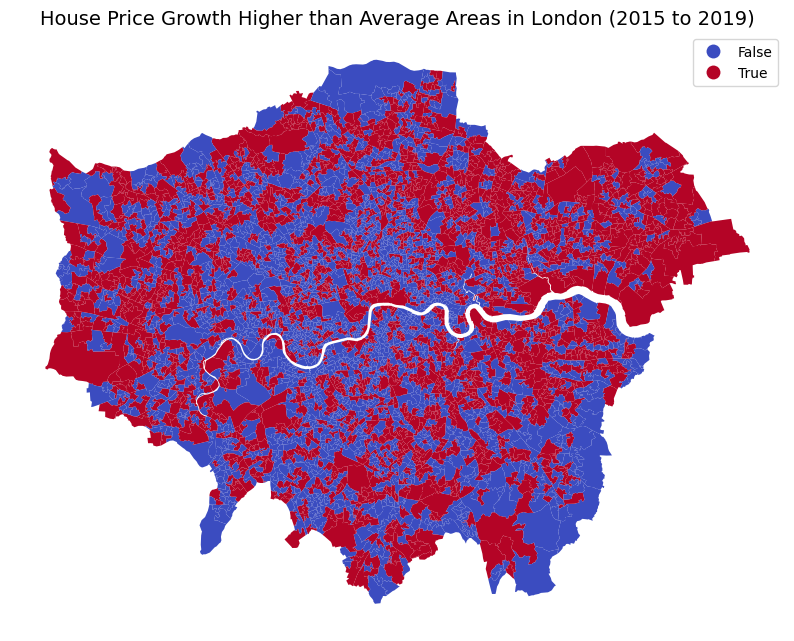

In [57]:
# show high house price areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='high_price_growth', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("House Price Growth Higher than Average Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

As shown in the figure, the areas where house prices rising rate higher than the average are mainly concentrated in the outer London regions, such as East London and West London. The rate of increase in housing prices in the city center is relatively low, possibly because the growth potential is limited or the market itself is already sufficiently saturated.

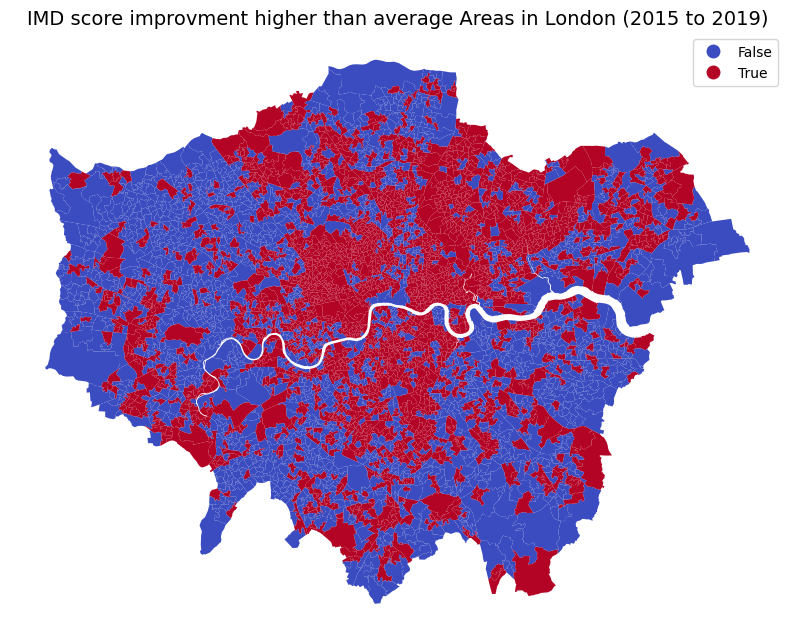

In [58]:
# show High imd scores areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='high_imd_improvement', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("IMD score improvment higher than average Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

However, the regions where the improvement rate of the IMD index was higher than the average were mostly concentrated in the inner London area, showing an opposite trend to the result of house prices.

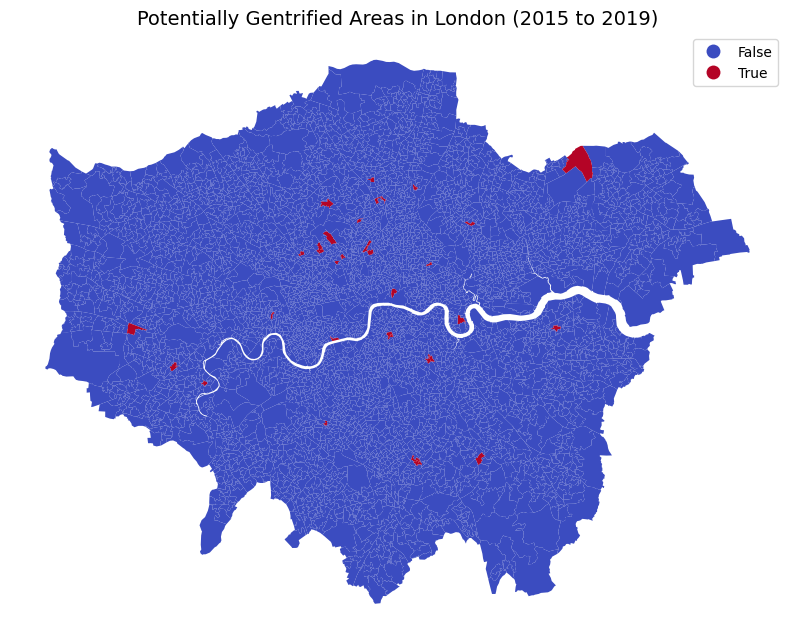

In [61]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='gentrified', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Potentially Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

Based on the results of the previous two graphs, we can see that within the London area, the gentrification phenomenon does not show a centralized trend but is rather scattered and mainly distributed in the surrounding areas outside the core urban area.

In [62]:
london_all_filled.columns

Index(['LSOA code', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN',
       'HHOLDS', 'AVHHOLDSZ', 'geometry', '2015_filled', '2019_filled',
       'centroid', '2015_final_knn', '2019_final_knn',
       'Index of Multiple Deprivation (IMD) Score_2015', 'LSOA name (2011)',
       'Index of Multiple Deprivation (IMD) Score_2019', 'imd_score_improve',
       'level_4_pop', 'level_4_per', 'prof_occ_count', 'prof_occ_per',
       'price_growth', 'price_growth_rate', 'high_price_growth',
       'high_imd_improvement', 'high_edu', 'high_occ', 'gentrified'],
      dtype='object')

In [63]:
columns_to_keep = ['LSOA code', 'LSOA11NM', 'geometry', 
                   '2019_final_knn', 'Index of Multiple Deprivation (IMD) Score_2019', 
                   'gentrified']
london_gentri_labeled = london_all_filled[columns_to_keep]

In [64]:
london_gentri_labeled.to_file("data/gentri_data/london_gentri_labeled.shp")

C:\Users\hp\AppData\Local\Temp\ipykernel_11884\1298374198.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  london_gentri_labeled.to_file("data/gentri_data/london_gentri_labeled.shp")
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '2019_final_knn' to '2019_final'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Index of Multiple Deprivation (IMD) Score_2019' to 'Index of M'
  ogr_write(


In [ ]:
# trying for the top 25%

price_growth_75 = london_all_filled['price_growth'].quantile(0.7)
imd_improve_75 = london_all_filled['imd_score_improve'].quantile(0.7)

# add labels for top 25%
london_all_filled['25_price_growth'] = london_all_filled['price_growth'] > price_growth_75
london_all_filled['25_imd_improvement'] = london_all_filled['imd_score_improve'] > imd_improve_75

# specific gentrified
london_all_filled[''] = london_all_filled['25_price_growth'] & london_all_filled['25_imd_improvement']
london_all_filled['gentrified2'] = london_all_filled['25_price_growth'] & london_all_filled['25_imd_improvement']
london_all_filled['gentrified2'].value_counts()

gentrified2
False    4398
True      437
Name: count, dtype: int64

In [ ]:
# # trying for the top 25%

# price_growth_75 = london_all_filled['price_growth'].quantile(0.75)
# imd_improve_75 = london_all_filled['imd_score_improve'].quantile(0.75)

# # add labels for top 25%
# london_all_filled['25_price_growth'] = london_all_filled['price_growth'] > price_growth_75
# london_all_filled['25_imd_improvement'] = london_all_filled['imd_score_improve'] > imd_improve_75

# # add labels for top 25%
# def classify(row):
#     if row['price_growth'] > price_growth_75 and row['imd_score_improve'] > imd_improve_75:
#         return 'gentrified2'
#     # elif row['price_growth'] > price_growth_75:
#     #     return 'high_price_only'
#     # elif row['imd_score_improve'] > imd_improve_75:
#     #     return 'imd_improvement_only'
#     else:
#         return 'non_gentrified'

# # specific gentrified
# london_all_filled['gentrified2'] = london_all_filled.apply(classify, axis=1)
# # london_all_filled['gentri_category'] = london_all_filled.apply(classify, axis=1)
# london_all_filled['gentrified2'].value_counts()

In [ ]:
columns_to_keep2 = ['LSOA code', 'LSOA11NM', 'geometry',
                   'imd_score_improve', 'price_growth', 
                   '2019_final_knn',
                   '25_price_growth', '25_imd_improvement', 'gentrified2']
london_gentri_labeled25 = london_all_filled[columns_to_keep2]
london_gentri_labeled25.to_file("data/gentri_data/london_gentri_labeled_25_only.shp")

C:\Users\hp\AppData\Local\Temp\ipykernel_2040\1888375610.py:6: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  london_gentri_labeled25.to_file("data/gentri_data/london_gentri_labeled_25_only.shp")
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'imd_score_improve' to 'imd_score_'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'price_growth' to 'price_grow'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '2019_final_knn' to '2019_final'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '25_price_growth' to '

In [ ]:
# columns_to_keep2 = ['LSOA code', 'LSOA11NM', 'geometry',
#                    'imd_score_improve', 'price_growth', 
#                    'high_price_growth', 'high_imd_improvment', 'gentri_category']
# london_gentri_labeled25 = london_all_filled[columns_to_keep2]
# london_gentri_labeled25.to_file("data/gentri_data/london_gentri_labeled_25_only.shp")

In [ ]:
print(london_gentri_labeled25.columns)

Index(['LSOA code', 'LSOA11NM', 'geometry', 'imd_score_improve',
       'price_growth', '2019_final_knn', '25_price_growth',
       '25_imd_improvement', 'gentrified2'],
      dtype='object')


In [ ]:
# # show gentrified areas in map
# fig, ax = plt.subplots(figsize=(10, 10))
# london_all_filled.plot(column='gentri_cat', cmap='coolwarm', legend=True, ax=ax)
# ax.set_title("Areas Experienced Significant Improvement in Deprivation", fontsize=14)
# ax.axis('off')
# plt.show()

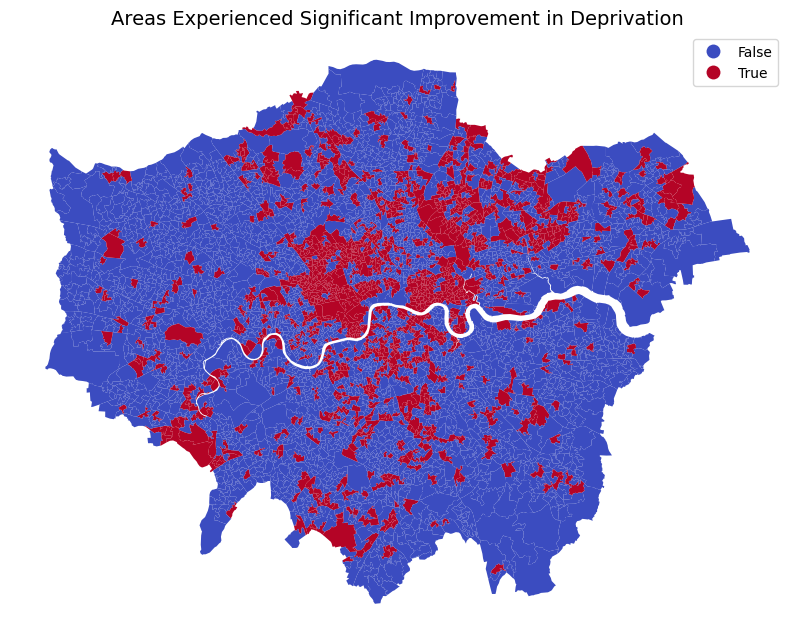

In [ ]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='25_imd_improvement', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Areas Experienced Significant Improvement in Deprivation", fontsize=14)
ax.axis('off')
plt.show()

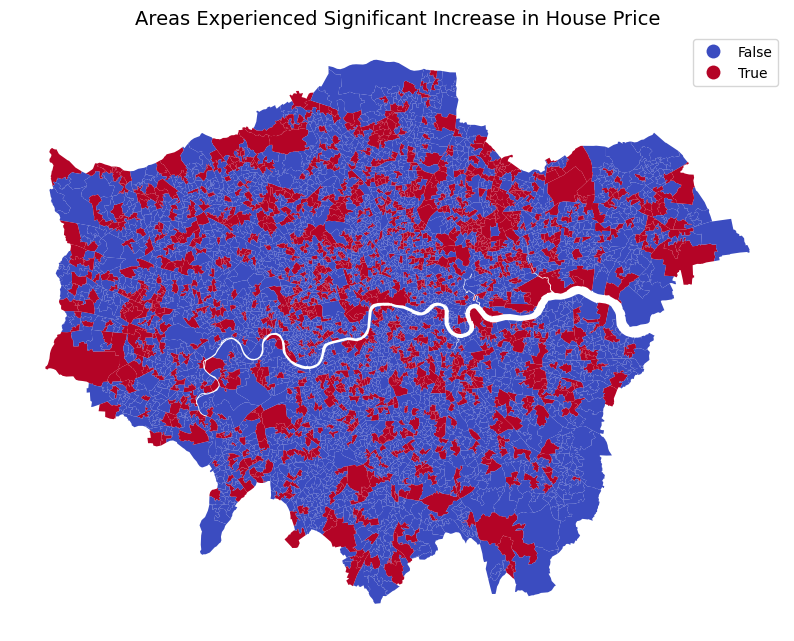

In [ ]:
# show house areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='25_price_growth', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Areas Experienced Significant Increase in House Price", fontsize=14)
ax.axis('off')
plt.show()

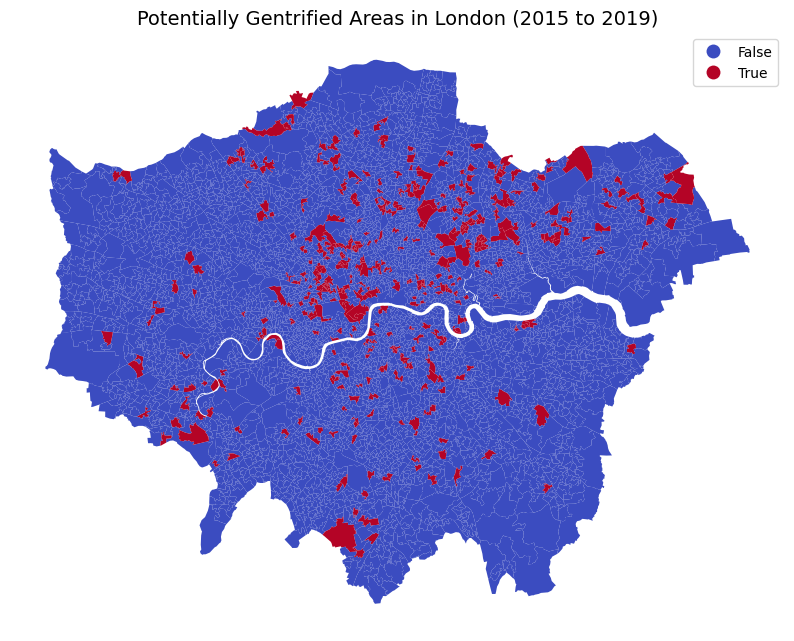

In [ ]:
# show gentrified areas in map
fig, ax = plt.subplots(figsize=(10, 10))
london_all_filled.plot(column='gentrified2', cmap='coolwarm', legend=True, ax=ax)
ax.set_title("Potentially Gentrified Areas in London (2015 to 2019)", fontsize=14)
ax.axis('off')
plt.show()

## Try Clustering

In [81]:
features_for_clustering = ['imd_score_improve', 'price_growth']

In [82]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(london_all_filled[features_for_clustering])

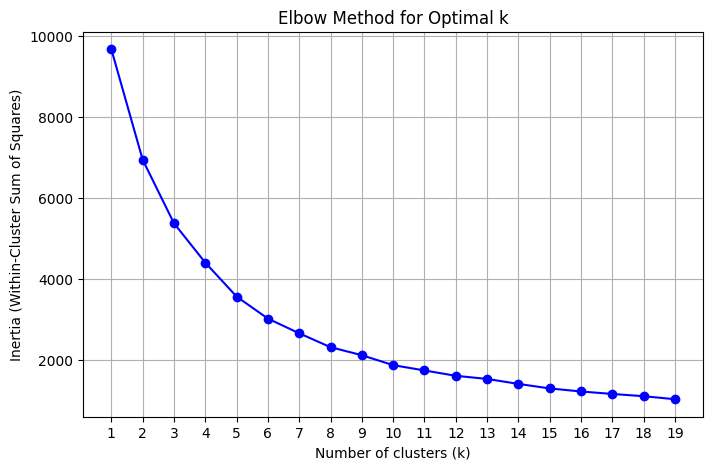

In [83]:
from sklearn.cluster import KMeans
# 3. 肘部法则计算
inertia = []
K_range = range(1, 20)  # 可自行扩大范围

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 4. 绘图
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [84]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

london_all_filled['gentri_cluster'] = clusters

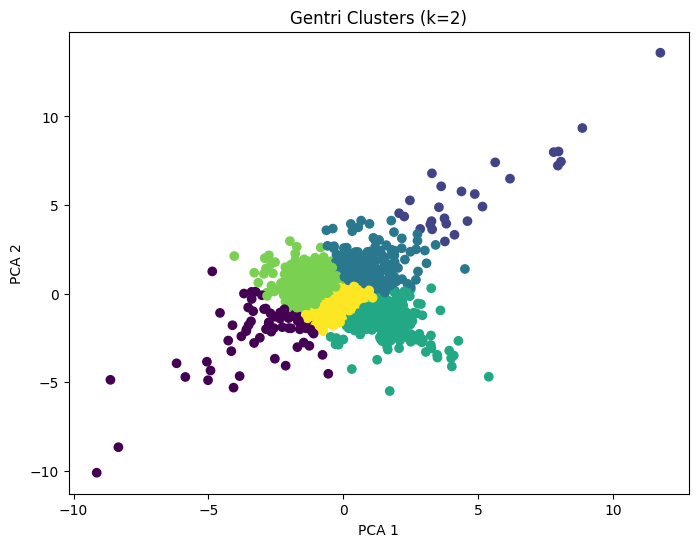

In [85]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Gentri Clusters (k=2)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


In [86]:
import pandas as pd

# 把聚类标签还原回原始变量
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                                columns=[features_for_clustering])

print(cluster_centers)

  imd_score_improve  price_growth
0          0.136453 -5.220191e+05
1          0.140248  1.263602e+06
2          0.104022  2.890922e+05
3         -0.172500  7.153550e+04
4          0.186898  4.659195e+04
5          0.033549  6.020798e+04


In [91]:
london_all_filled['gentrified3'] = (london_all_filled['gentri_cluster'] == 4).astype(int)
cluster_col_keep = ['LSOA code','gentrified3','gentri_cluster','geometry']
london_cludter = london_all_filled[cluster_col_keep]
print(london_cludter.columns)

Index(['LSOA code', 'gentrified3', 'gentri_cluster', 'geometry'], dtype='object')


In [92]:
london_cludter.to_file("data/gentri_data/london_gentri_labeled_clustering.shp")

C:\Users\hp\AppData\Local\Temp\ipykernel_11884\4089829898.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  london_cludter.to_file("data/gentri_data/london_gentri_labeled_clustering.shp")
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'gentrified3' to 'gentrified'
  ogr_write(
e:\dissertation\project\housing_feature_gentrification\venv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'gentri_cluster' to 'gentri_clu'
  ogr_write(


In [93]:
from matplotlib.patches import Patch

# 自定义每个聚类的颜色
cluster_colors = {
    0: 'grey',
    1: 'grey',
    2: 'grey',
    3: 'grey',
    4: 'red',
    5: 'grey'
}

# 可选：自定义每个类别的文字标签（按你的聚类中心结果来写）
cluster_labels = {
    0: '0',
    1: '1',
    2: '2',
    3: '3',
    4: '4',
    5: '5'
}
london_all_filled['cluster_color'] = london_all_filled['gentri_cluster'].map(cluster_colors)

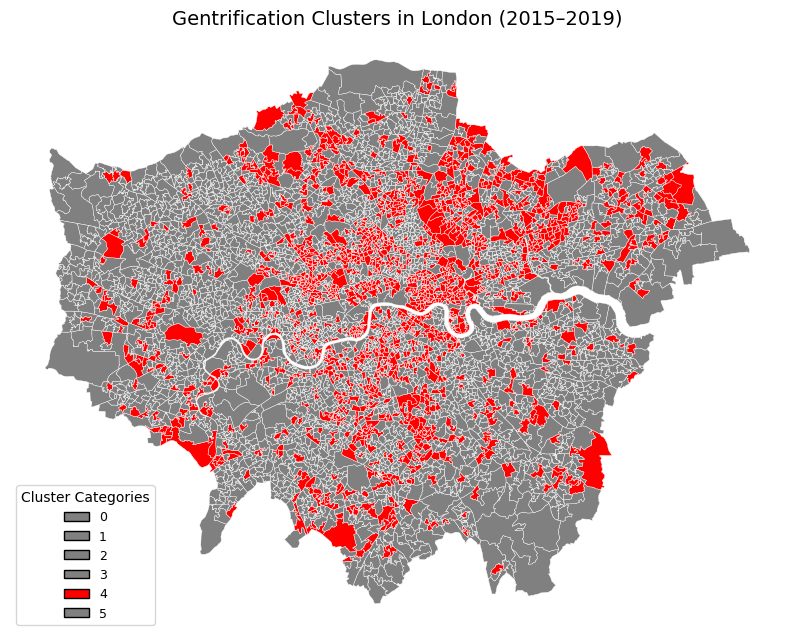

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))

# 绘图，不使用默认 legend
london_all_filled.plot(color=london_all_filled['cluster_color'], ax=ax, edgecolor='white', linewidth=0.3)

# 构造图例元素
legend_elements = [
    Patch(facecolor=cluster_colors[i], edgecolor='black', label=cluster_labels[i]) for i in range(6)
]

# 添加图例
ax.legend(handles=legend_elements, title='Cluster Categories', loc='lower left', fontsize=9)
ax.set_title("Gentrification Clusters in London (2015–2019)", fontsize=14)
ax.axis('off')

plt.show()